## Download

In [1]:
# /content/Ethos_Dataset_Binary.csv
!gdown 1QKJ4qqfc_EcO8nDghtp0L1dSNGqlw6R8 

Downloading...
From: https://drive.google.com/uc?id=1QKJ4qqfc_EcO8nDghtp0L1dSNGqlw6R8
To: /content/Ethos_Dataset_Binary.csv
100% 124k/124k [00:00<00:00, 82.0MB/s]


In [45]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


## Imports

In [26]:
import polars as pl
import numpy as np
import catboost
import json
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

## Reading data

In [3]:
df = pl.read_csv("/content/Ethos_Dataset_Binary.csv", separator=';')

In [4]:
df[0:5]

comment,isHate
str,f64
"""You should kno…",1.0
"""You look like …",1.0
"""You look like …",1.0
"""Women deserve …",1.0
"""Women are made…",1.0


## Splitting a dataset into train and test

In [6]:
X = df['comment']
y = df['isHate']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [8]:
# for logging in DVC
train = pl.DataFrame([X_train, y_train])
test = pl.DataFrame([X_test, y_test])

train.write_csv('train.csv')
test.write_csv('test.csv')

## Feature extraction

In [12]:
# Init tf-idf
vect_word = TfidfVectorizer(
    max_features=200,
    lowercase=True,
    analyzer="word",
    stop_words="english",
    ngram_range=(1, 5),
    dtype=np.float32
)

In [13]:
# Train tf-idf
X_train_tfidf = vect_word.fit_transform(X_train)
# Map tf-idf on test
X_test_tfidf = vect_word.transform(X_test)

## Baseline model training

In [28]:
cat_regr = catboost.CatBoostRegressor()

In [29]:
train_dataset = catboost.Pool(
    X_train_tfidf,
    y_train.to_pandas()
)

In [30]:
test_dataset = catboost.Pool(
    X_test_tfidf,
    y_test.to_pandas()
)

In [31]:
cat_regr.fit(
    train_dataset,
    eval_set=test_dataset,
    verbose=100,
)

Learning rate set to 0.048126
0:	learn: 0.3931903	test: 0.3854506	best: 0.3854506 (0)	total: 11.4ms	remaining: 11.4s
100:	learn: 0.3509274	test: 0.3615031	best: 0.3615031 (100)	total: 1.06s	remaining: 9.47s
200:	learn: 0.3225932	test: 0.3521206	best: 0.3521206 (200)	total: 2.03s	remaining: 8.09s
300:	learn: 0.2993534	test: 0.3493200	best: 0.3489511 (279)	total: 2.69s	remaining: 6.25s
400:	learn: 0.2816374	test: 0.3487998	best: 0.3487998 (400)	total: 3.05s	remaining: 4.56s
500:	learn: 0.2672152	test: 0.3496114	best: 0.3487998 (400)	total: 3.4s	remaining: 3.39s
600:	learn: 0.2556407	test: 0.3508111	best: 0.3487998 (400)	total: 3.81s	remaining: 2.53s
700:	learn: 0.2456426	test: 0.3525299	best: 0.3487998 (400)	total: 4.15s	remaining: 1.77s
800:	learn: 0.2368217	test: 0.3548911	best: 0.3487998 (400)	total: 4.51s	remaining: 1.12s
900:	learn: 0.2290222	test: 0.3566490	best: 0.3487998 (400)	total: 4.87s	remaining: 535ms
999:	learn: 0.2224694	test: 0.3588495	best: 0.3487998 (400)	total: 5.22s	r

In [38]:
rmse = mean_squared_error(list(y_test), cat_regr.predict(X_test_tfidf))**(1/2)
print(rmse)

0.34879983310874124


In [39]:
cat_regr.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04812600091099739,
 'score_function': 'Cosine',
 'task_type':

In [42]:
# for logging in DVC

baseline_model_params = dict()
baseline_model_params['params'] = cat_regr.get_all_params()
baseline_model_params['RMSE'] = rmse

with open('baseline_model_params.json', 'w') as file:
    json.dump(baseline_model_params, file)   

In [117]:
with open('cat_regr_baseline_model.pkl', mode='wb') as file:
        pickle.dump(cat_regr, file)

## Hyperparameter enumeration

In [46]:
import optuna

In [76]:
def objective_cat(trial):
    
    param = {
        'n_estimators': 
            trial.suggest_categorical('n_estimators', 
                                      range(1000, 4001, 500)),
        'penalties_coefficient': 
            trial.suggest_categorical('penalties_coefficient',
                                      [x/100 for x in range(80, 151, 5)]),
        'learning_rate': 
            trial.suggest_categorical('learning_rate',
                                      [x/1000 for x in range(30, 101, 5)]),
        'subsample': 
            trial.suggest_categorical('subsample',
                                      [x/100 for x in range(50, 101, 5)]),
        'min_child_samples': 
            trial.suggest_int('min_child_samples', 
                              100, 300),
        'max_depth': 
            trial.suggest_categorical('max_depth', 
                                      range(4, 9, 1)),
        'l2_leaf_reg':
            trial.suggest_categorical('l2_leaf_reg',
                                      [x/10 for x in range(20, 41, 5)]),
        'model_size_reg':
            trial.suggest_categorical('model_size_reg', 
                                      [x/100 for x in range(20, 80, 5)])
    }

    model = catboost.CatBoostRegressor(**param)  
    
    model.fit(X_train_tfidf, 
              y_train.to_pandas(), 
              eval_set=test_dataset, 
              early_stopping_rounds=750, 
              verbose=False)
    
    preds = model.predict(X_test_tfidf)
    score = mean_squared_error(list(y_test), preds)**(1/2)
    
    return score

In [77]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_cat, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-06-03 12:16:30,306] A new study created in memory with name: no-name-e166fc6f-1f0e-41d4-b485-e416cb44e66a
[I 2023-06-03 12:16:43,206] Trial 0 finished with value: 0.35000886158783406 and parameters: {'n_estimators': 2000, 'penalties_coefficient': 1.05, 'learning_rate': 0.035, 'subsample': 0.65, 'min_child_samples': 298, 'max_depth': 8, 'l2_leaf_reg': 2.5, 'model_size_reg': 0.7}. Best is trial 0 with value: 0.35000886158783406.
[I 2023-06-03 12:16:47,776] Trial 1 finished with value: 0.35133710568568827 and parameters: {'n_estimators': 2500, 'penalties_coefficient': 1.1, 'learning_rate': 0.065, 'subsample': 0.5, 'min_child_samples': 205, 'max_depth': 5, 'l2_leaf_reg': 2.5, 'model_size_reg': 0.4}. Best is trial 0 with value: 0.35000886158783406.
[I 2023-06-03 12:16:51,649] Trial 2 finished with value: 0.35015502821466193 and parameters: {'n_estimators': 4000, 'penalties_coefficient': 1.1, 'learning_rate': 0.075, 'subsample': 0.75, 'min_child_samples': 203, 'max_depth': 6, 'l2_lea

Number of finished trials: 30
Best trial: {'n_estimators': 1500, 'penalties_coefficient': 0.8, 'learning_rate': 0.055, 'subsample': 0.8, 'min_child_samples': 137, 'max_depth': 6, 'l2_leaf_reg': 3.0, 'model_size_reg': 0.2}


In [78]:
optuna.visualization.plot_optimization_history(study)

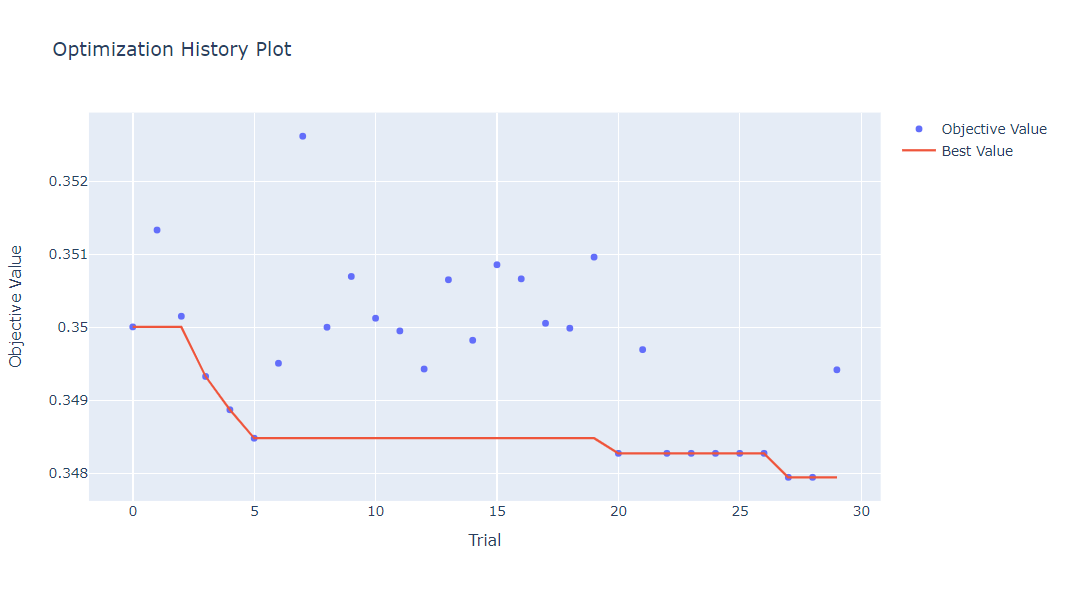

In [83]:
optuna.visualization.plot_param_importances(study)

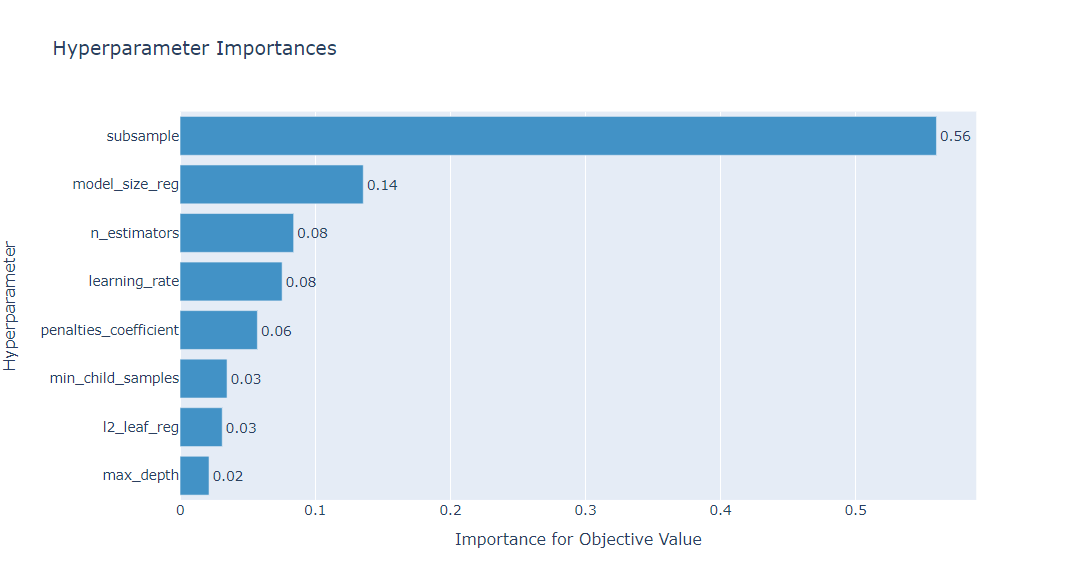

## Maintaining the best model

In [108]:
cat_regr_best_model = catboost.CatBoostRegressor(**study.best_trial.params)

In [109]:
cat_regr_best_model.fit(
    train_dataset,
    eval_set=test_dataset,
    verbose=100
)

0:	learn: 0.3930855	test: 0.3853652	best: 0.3853652 (0)	total: 3.79ms	remaining: 5.68s
100:	learn: 0.3464000	test: 0.3603761	best: 0.3603761 (100)	total: 378ms	remaining: 5.23s
200:	learn: 0.3138016	test: 0.3495128	best: 0.3493683 (199)	total: 762ms	remaining: 4.92s
300:	learn: 0.2910380	test: 0.3482603	best: 0.3482338 (283)	total: 1.14s	remaining: 4.54s
400:	learn: 0.2720835	test: 0.3492223	best: 0.3479465 (305)	total: 1.5s	remaining: 4.11s
500:	learn: 0.2584655	test: 0.3498307	best: 0.3479465 (305)	total: 1.87s	remaining: 3.74s
600:	learn: 0.2470586	test: 0.3524643	best: 0.3479465 (305)	total: 2.24s	remaining: 3.36s
700:	learn: 0.2367996	test: 0.3545332	best: 0.3479465 (305)	total: 2.62s	remaining: 2.98s
800:	learn: 0.2281932	test: 0.3565478	best: 0.3479465 (305)	total: 2.99s	remaining: 2.61s
900:	learn: 0.2206622	test: 0.3588137	best: 0.3479465 (305)	total: 3.38s	remaining: 2.25s
1000:	learn: 0.2140951	test: 0.3605145	best: 0.3479465 (305)	total: 3.74s	remaining: 1.86s
1100:	learn: 

In [110]:
cat_regr_best_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1500,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 0.800000011920929,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.20000000298023224,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 137,
 'loss_function': 'RMSE',
 'learning_rate': 0.054999999701976776,
 'score

In [111]:
rmse = mean_squared_error(list(y_test), cat_regr_best_model.predict(X_test_tfidf))**(1/2)
print(rmse)

0.3479464940483275


In [112]:
# for logging in DVC

cat_regr_best_model_params = dict()
cat_regr_best_model_params['params'] = cat_regr_best_model.get_all_params()
cat_regr_best_model_params['RMSE'] = rmse

with open('cat_regr_best_model_params.json', 'w') as file:
    json.dump(cat_regr_best_model_params, file) 

In [114]:
with open('cat_regr_best_model.pkl', mode='wb') as file:
        pickle.dump(cat_regr_best_model, file)